# Clasificación de imagenes desde cero

## Introducción

Este ejemplo muestra cómo realizar clasificación de imágenes desde cero, comenzando con archivos de imagen JPEG en el disco, sin aprovechar pesos pre-entrenados o un modelo de aplicación Keras prefabricado. Demostramos el flujo de trabajo en el conjunto de datos de clasificación binaria Kaggle Cats vs Dogs (Gatos contra Perros).
Utilizamos la utilidad <code>image_dataset_from_directory</code> para generar los conjuntos de datos y empleamos capas de preprocesamiento de imágenes de Keras para la estandarización de imágenes y el aumento de datos.

In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

## Filtrar imágenes corruptas.

Al trabajar con grandes cantidades de datos de imágenes del mundo real, las imágenes corruptas son algo común. Vamos a filtrar las imágenes mal codificadas que no contienen la cadena "JFIF" en su encabezado.

In [2]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("../PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Borrar imagenes corruptas
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


## Generar un <code>Dataset</code>

In [3]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "../PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Using 4684 files for validation.


## Visualizar los datos

Aquí están las primeras 9 imágenes en el conjunto de datos de entrenamiento.

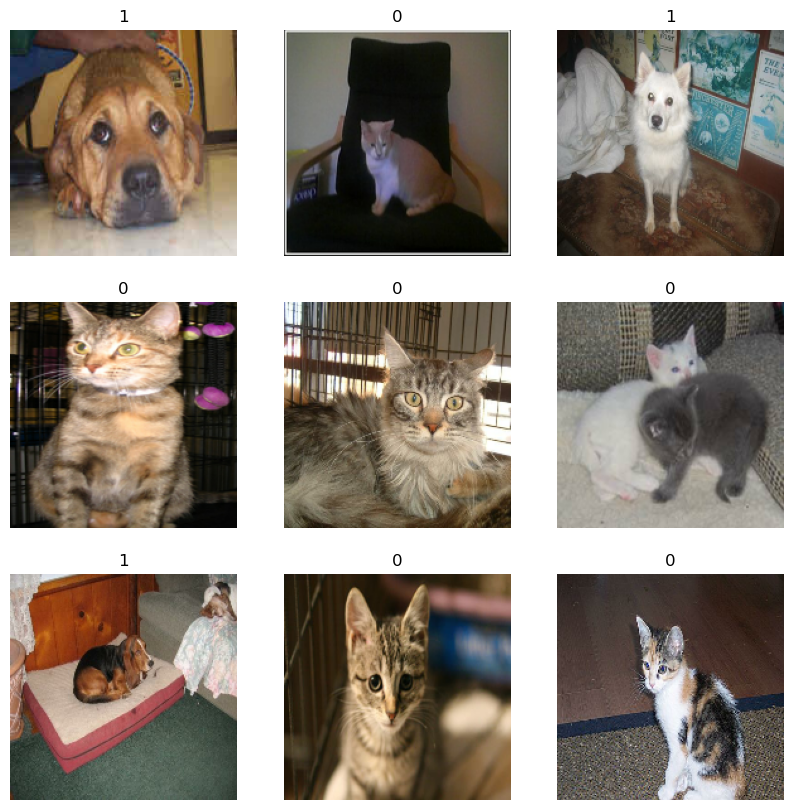

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Usar el aumento de datos de imágenes
Cuando no se dispone de un conjunto de datos de imágenes grande, es una buena práctica introducir diversidad de muestras de forma artificial aplicando transformaciones aleatorias pero realistas a las imágenes de entrenamiento, como volteos horizontales aleatorios o pequeñas rotaciones aleatorias. Esto ayuda a exponer el modelo a diferentes aspectos de los datos de entrenamiento al tiempo que se ralentiza el sobreajuste.

In [5]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

Visualicemos cómo se ven las muestras aumentadas, aplicando <code>data_augmentation</code> repetidamente a las primeras imágenes del conjunto de datos:

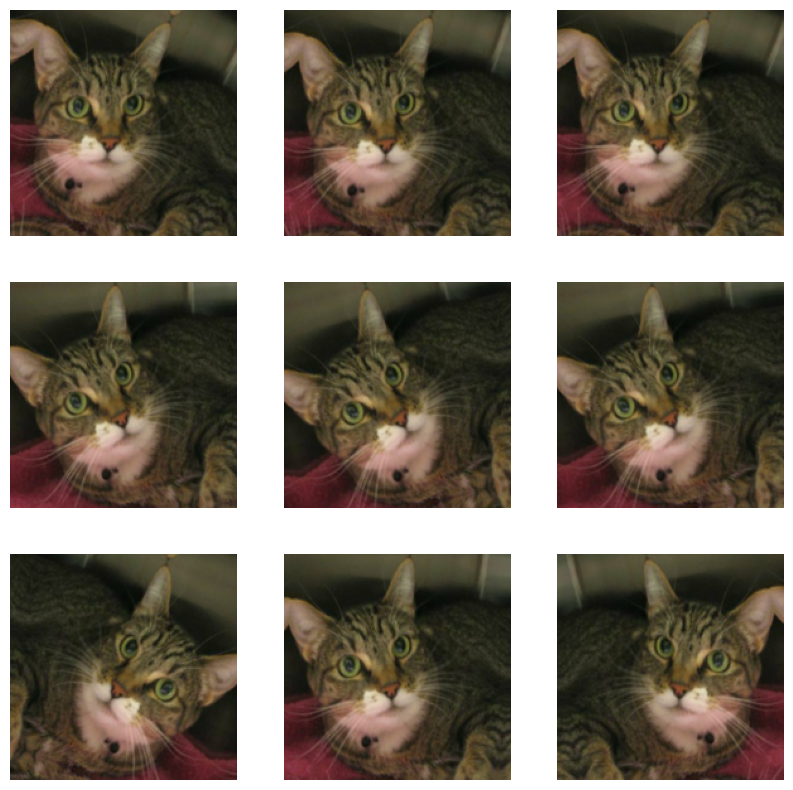

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

## Estandarización de los datos

Nuestras imágenes ya tienen un tamaño estándar (180x180), ya que nuestro conjunto de datos las genera como lotes contiguos de <code>float32</code>. Sin embargo, sus valores de canal RGB están en el rango <code>[0, 255]</code>. Esto no es ideal para una red neuronal; en general, deberías intentar que tus valores de entrada sean pequeños. Aquí, estandarizaremos los valores para que estén en el rango <code>[0, 1]</code> utilizando una capa <code>Rescaling</code> al inicio de nuestro modelo.

<hr>

## Dos opciones para preprocesar los datos

Hay dos formas en las que podrías usar el preprocesador <code>data_augmentation:</code>

**Opción 1: Hacerlo parte del modelo**, así:

In [ ]:
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Resto del modelo

Con esta opción, el aumento de datos ocurrirá en el dispositivo, sincrónicamente con el resto de la ejecución del modelo, lo que significa que se beneficiará de la aceleración de la GPU.

Ten en cuenta que el aumento de datos está inactivo en el momento de la prueba, por lo que las muestras de entrada solo se aumentarán durante <code>fit()</code>, no al llamar a <code>evaluate()</code> o <code>predict()</code>.

Si estás entrenando en la GPU, esta puede ser una buena opción.

**Opción 2: aplicarlo al conjunto de datos**, para obtener un conjunto de datos que genere lotes de imágenes aumentadas, así:

In [ ]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

Con esta opción, el aumento de datos ocurrirá **en la CPU**, de forma asíncrona, y se almacenará en un búfer antes de ingresar al modelo.

Si estás entrenando en la CPU, esta es la mejor opción, ya que hace que el aumento de datos sea asíncrono y no bloqueante.

En nuestro caso, elegiremos la segunda opción. Si no estás seguro de cuál elegir, esta segunda opción (preprocesamiento asíncrono) siempre es una elección sólida.

<hr>

## Configuremos el conjunto de datos para obtener un buen rendimiento.

Apliquemos el aumento de datos a nuestro conjunto de datos de entrenamiento y asegurémonos de utilizar el prefetching con búfer para poder obtener datos del disco sin que las operaciones de E/S se vuelvan bloqueantes:

In [7]:
# Aplicar `data_augmentation` al entrenamiento de imagenes.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Precarga de muestras en la memoria de la GPU ayuda a maximizar su utilización.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

## Construir un modelo

Construiremos una versión pequeña de la red Xception. No hemos intentado particularmente optimizar la arquitectura; si deseas realizar una búsqueda sistemática de la mejor configuración del modelo, considera usar KerasTuner.

Ten en cuenta que:

- Comenzamos el modelo con el preprocesador data_augmentation, seguido de una capa Rescaling.

- Incluimos una capa Dropout antes de la capa de clasificación final.

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Bloque de entrada
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Reservar el residuo

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Proyecto residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # agregagar residuo anterior
        previous_block_activation = x  # obtener el residuo para la siguiente iteración

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # Especificamos activation=None para que se devuelvan los logits.
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Entrenar el modelo

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Alcanzamos una precisión de validación superior al 90% después de entrenar durante 25 épocas en el conjunto de datos completo (en la práctica, puedes entrenar durante más de 50 épocas antes de que el rendimiento de la validación comience a degradarse).

<hr>

## Ejecutar inferencia en datos nuevos
Ten en cuenta que el aumento de datos y el dropout están inactivos en el momento de la inferencia.

In [ ]:
img = keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Crear un eje de lote.

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")